In [11]:
import os, json, zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Increase default figure size
plt.rcParams['figure.figsize'] = (6, 4)
# --- PATH TO YOUR RESULTS ----------------------------------------------------
RESULTS_DIR = Path('../results')
FIGURE_DIR = Path('../figures')

# -----------------------------------------------------------------------------
# Plot-style constants – tweak to taste
FIGSIZE            = (10, 8)   # inches
TITLE_SIZE         = 22
LABEL_SIZE         = 18
TICK_SIZE          = 14
LEGEND_SIZE        = 14
LINEWIDTH          = 2.5
MARKERSIZE         = 9

plt.rcParams.update({
    "figure.figsize":   FIGSIZE,
    "axes.titlesize":   TITLE_SIZE,
    "axes.labelsize":   LABEL_SIZE,
    "xtick.labelsize":  TICK_SIZE,
    "ytick.labelsize":  TICK_SIZE,
    "legend.fontsize":  LEGEND_SIZE,
    "lines.linewidth":  LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

FIGURE_EXTENSION = "png"

In [12]:
# Ensure it exists
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Results directory {RESULTS_DIR} does not exist.")

# Create figure directory if it doesn't exist
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
import os
import re
import json
import numpy as np
import pandas as pd

def parse_results(results_dir, *, high_eps_marker='high_eps', split=True):
    """
    Walks through results_dir/<dataset>_dataset/*.json and returns up to
    three DataFrames:

        df_all, df_regular, df_high_eps = parse_results(...)

    *Index*  : (dataset, epsilon, n_queries)  
    *Columns*: technique, delta, high_eps, and for every metric found:
               <metric>, std_<metric>

    Parameters
    ----------
    results_dir : str
        Root directory that contains <dataset>_dataset sub-folders.
    high_eps_marker : str, default 'high_eps'
        Sub-string that must appear in an AGT filename to flag it as a
        “high-ε” extension run.
    split : bool, default True
        If False, only `df_all` is returned.

    Returns
    -------
    df_all : pandas.DataFrame
        All runs, including a boolean column ``high_eps``.
    df_regular : pandas.DataFrame
        Sub-set where ``high_eps == False`` (only returned if *split* is True).
    df_high_eps : pandas.DataFrame
        Sub-set where ``high_eps == True``  (only returned if *split* is True).
    """
    # fixed δ for DPSGD/AGT, by dataset
    delta_map = {
        'adult':      1e-5,
        'acs_income': 1e-6,
    }

    rows = []

    for root, _, files in os.walk(results_dir):
        if not root.endswith('_dataset'):
            continue

        dataset = os.path.basename(root).replace('_dataset', '')

        for fname in files:
            if not fname.endswith('.json') or fname.startswith('._'):
                continue

            path  = os.path.join(root, fname)
            base  = fname[:-5]                      # drop “.json”
            assert base.startswith(dataset + '_'), f"Unexpected file name {fname}"
            rest  = base[len(dataset) + 1:]         # after "<dataset>_"
            tech  = rest.split('_', 1)[0]           # 'sgd', 'dpsgd', or 'agt'

            with open(path, 'r') as f:
                data = json.load(f)

            # flag any AGT file that contains the marker as “high-eps”
            is_high_eps_file = (tech == 'agt') and (high_eps_marker in rest)

            if tech in ('sgd', 'dpsgd'):
                # ──────────────────────── SGD / DPSGD ────────────────────────
                if tech == 'sgd':          # non-DP baseline
                    eps, delta = np.inf, np.nan
                else:                      # DPSGD_<eps>_<delta>
                    m = re.match(
                        r'dpsgd_eps(?P<eps>[\d\.eE\-\+]+)_delta(?P<delta>[\d\.eE\-\+]+)',
                        rest
                    )
                    eps   = float(m.group('eps'))
                    delta = float(m.group('delta'))

                row = {
                    'dataset':   dataset,
                    'technique': tech,
                    'epsilon':   eps,
                    'delta':     delta,
                    'n_queries': np.nan,
                    'high_eps':  False,            # never high-ε
                }
                for metric, val in data.items():
                    row[metric]          = val
                    row['std_' + metric] = np.nan

                rows.append(row)

            elif tech == 'agt':
                # ─────────────────────────── AGT ────────────────────────────
                delta = delta_map[dataset]
                for idx_key, stats in data.items():     # "<n_queries>_<eps>"
                    n_q_str, eps_str = idx_key.split('_', 1)
                    n_q = int(n_q_str)
                    eps  = float(eps_str)

                    row = {
                        'dataset':   dataset,
                        'technique': tech,
                        'epsilon':   eps,
                        'delta':     delta,
                        'n_queries': n_q,
                        'high_eps':  is_high_eps_file,
                    }
                    for metric, mstats in stats.items():
                        row[metric]          = mstats['mean']
                        row['std_' + metric] = mstats['std']

                    rows.append(row)

            else:
                raise ValueError(f"Unrecognised technique: {tech}")

    # ────────────────────────── build DataFrames ────────────────────────────
    df_all = (
        pd.DataFrame(rows)
          .set_index(['dataset', 'epsilon', 'n_queries'])
          .sort_index()
    )

    if not split:
        return df_all

    df_high_eps = df_all[df_all['high_eps']].copy()
    df_regular  = df_all[~df_all['high_eps']].copy()

    # drop the flag inside the split views to keep them tidy
    for _df in (df_high_eps, df_regular):
        _df.drop(columns='high_eps', inplace=True)

    return df_all, df_regular, df_high_eps

In [14]:
# Parse results and get dataframes

df_all, df_regular, df_high_eps = parse_results(RESULTS_DIR)

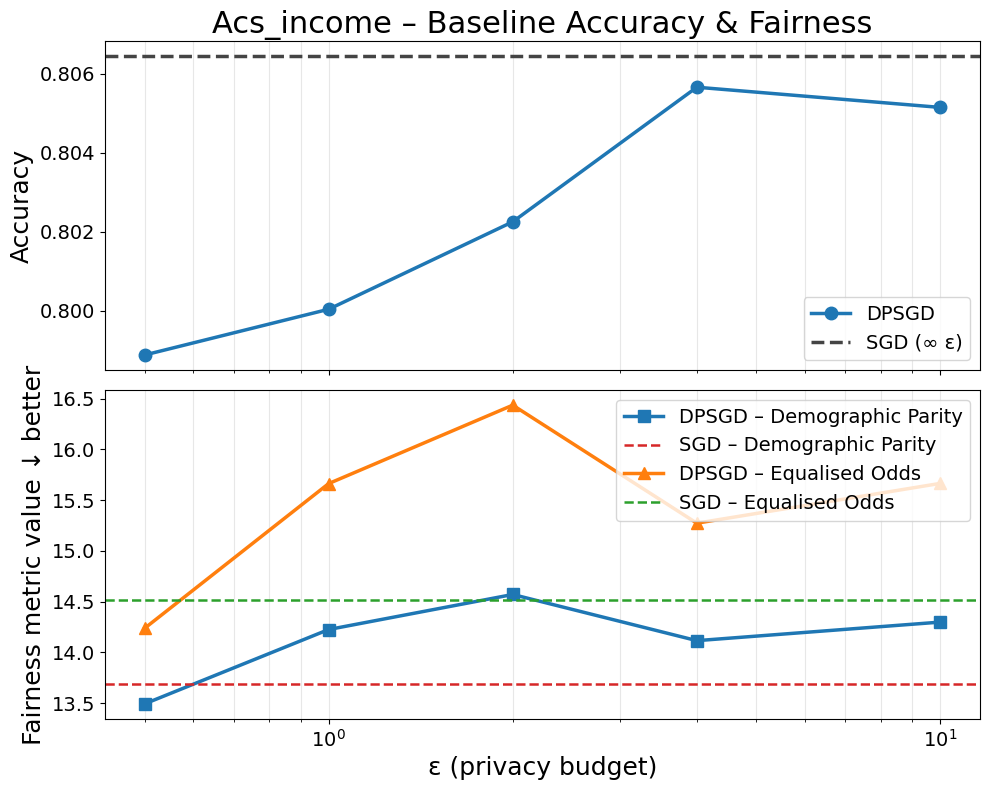

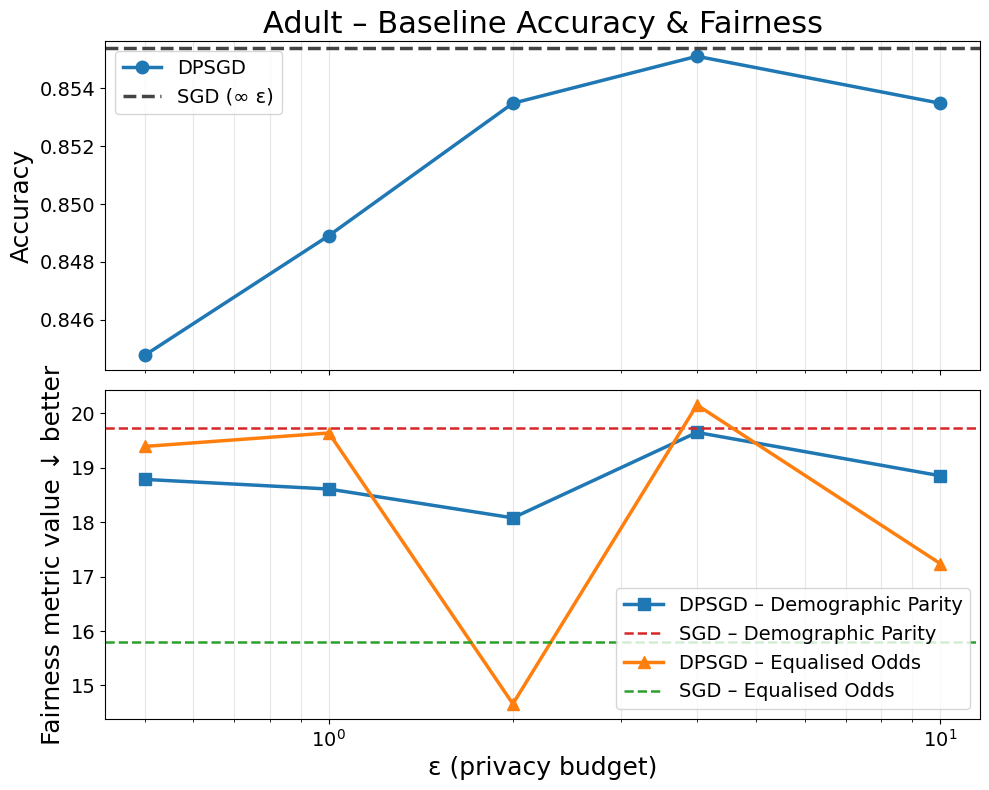

In [ ]:
# --- DATA LOADING ------------------------------------------------------------

# keep only the baseline techniques
BASELINES = df_regular[df_regular["technique"].isin(["sgd", "dpsgd"])]

# --- PLOTTING FUNCTION -------------------------------------------------------
def baseline_plots(df=BASELINES, *, save=False, out_dir=FIGURE_DIR):
    """
    One figure per dataset, showing
      • accuracy vs ε   (DPSGD curve + SGD baseline)
      • two fairness metrics vs ε, each with its *own-coloured* SGD baseline.
    """
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    # pick two visually distinct colours for the SGD fairness baselines
    SGD_COLORS = {
        "demographic_parity": "#d62728",  # reddish
        "equalised_odds":     "#2ca02c",  # greenish
    }

    for dataset, g in df.groupby(level="dataset"):
        sgd_row = g[g["technique"] == "sgd"].iloc[0]
        dpsgd   = g[g["technique"] == "dpsgd"].reset_index()

        fig, (ax_acc, ax_fair) = plt.subplots(2, 1, sharex=True)

        # ─── ACCURACY ───────────────────────────────────────────────────────
        ax_acc.plot(dpsgd["epsilon"], dpsgd["accuracy"],
                    marker="o", label="DPSGD")
        ax_acc.axhline(sgd_row["accuracy"], linestyle="--",
                       color="#444444", label="SGD (∞ ε)")
        ax_acc.set_xscale("log")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.set_title(f"{dataset.capitalize()} – Baseline Accuracy & Fairness")
        ax_acc.grid(True, which="both", axis="x", alpha=0.3)
        ax_acc.legend()

        # ─── FAIRNESS METRICS ──────────────────────────────────────────────
        metric_styles = {
            "demographic_parity": "-s",
            "equalised_odds":     "-^",
        }
        for metric, style in metric_styles.items():
            pretty = metric.replace("_", " ").title()
            # DPSGD curve
            ax_fair.plot(dpsgd["epsilon"], dpsgd[metric],
                         style, label=f"DPSGD – {pretty}")
            # SGD baseline in its own colour
            ax_fair.axhline(
                sgd_row[metric], linestyle="--", linewidth=1.8,
                color=SGD_COLORS[metric], label=f"SGD – {pretty}"
            )

        ax_fair.set_xscale("log")
        ax_fair.set_xlabel("ε (privacy budget)")
        ax_fair.set_ylabel("Fairness metric value ↓ better")
        ax_fair.grid(True, which="both", axis="x", alpha=0.3)
        ax_fair.legend()

        plt.tight_layout()
        if save:
            fig.savefig(out_dir / f"{dataset}_baseline.{FIGURE_EXTENSION}", dpi=300)
        plt.show()

# ----------------------------- DRIVER ----------------------------------------
baseline_plots(save=True)   # set save=True to write files

In [38]:
# ───────────────────────────── DATA ──────────────────────────────────────────
# Focus only on AGT high-ε runs
AGT_HIGH = df_high_eps[df_high_eps["technique"] == "agt"].copy()


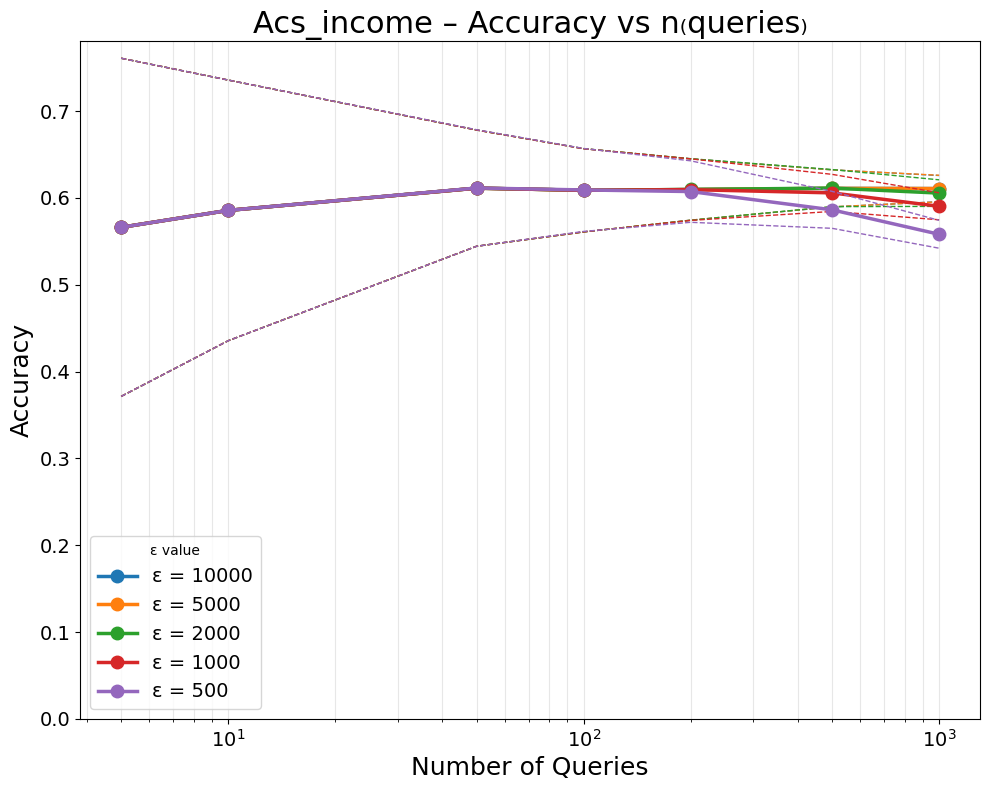

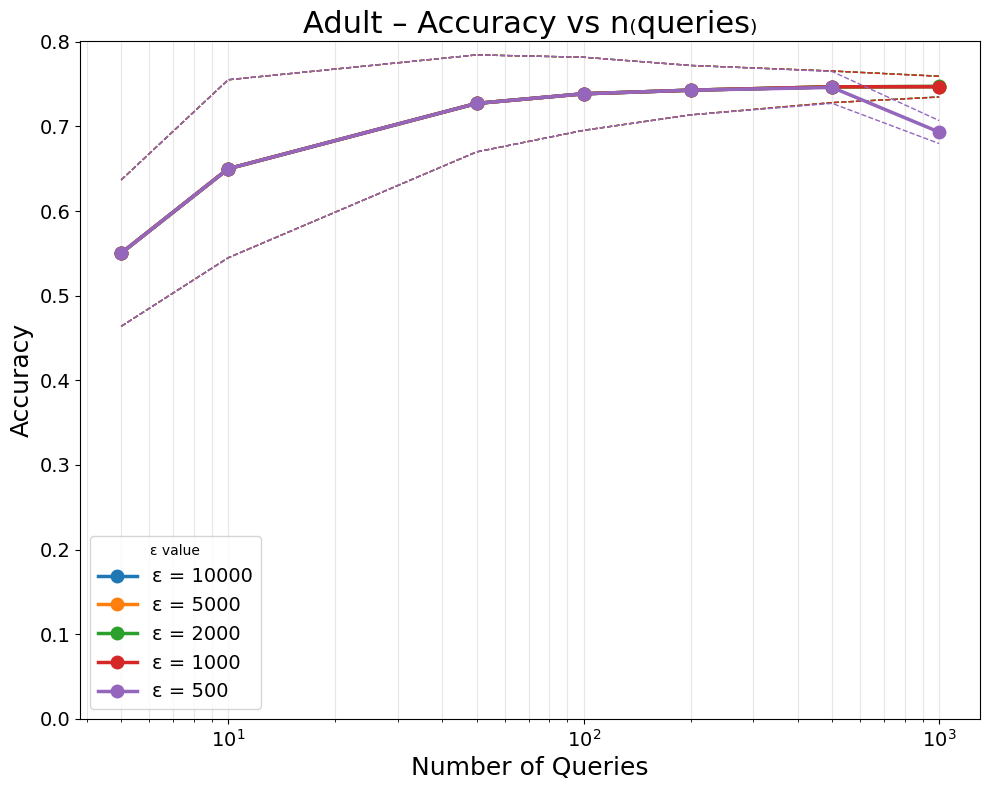

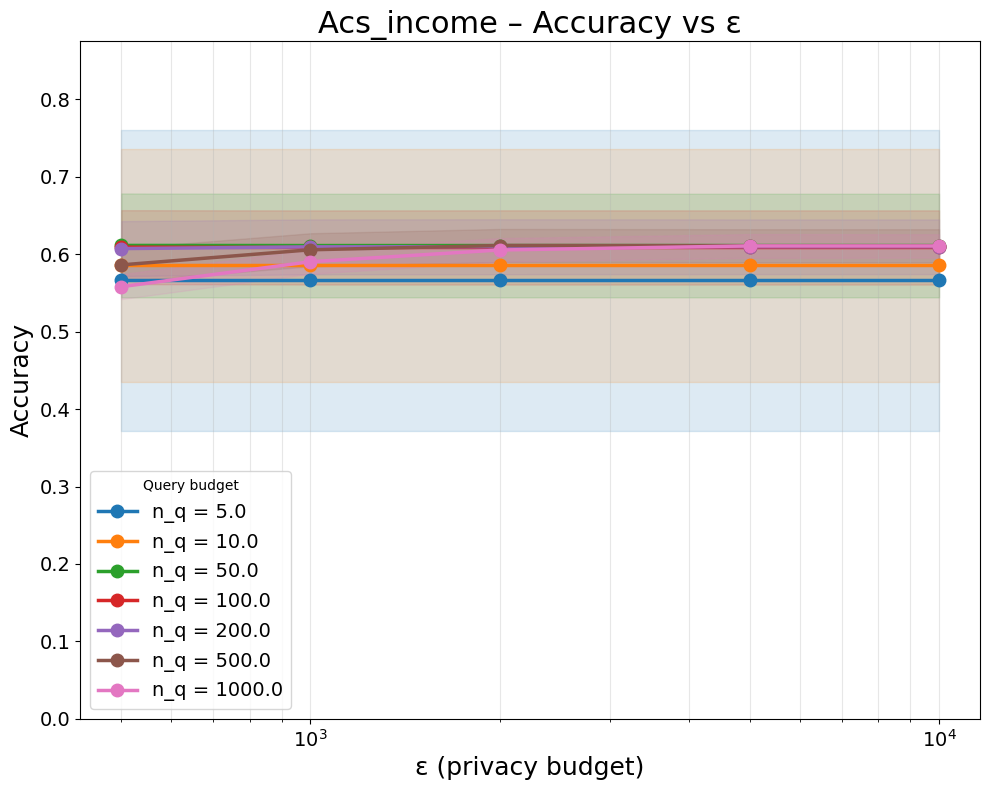

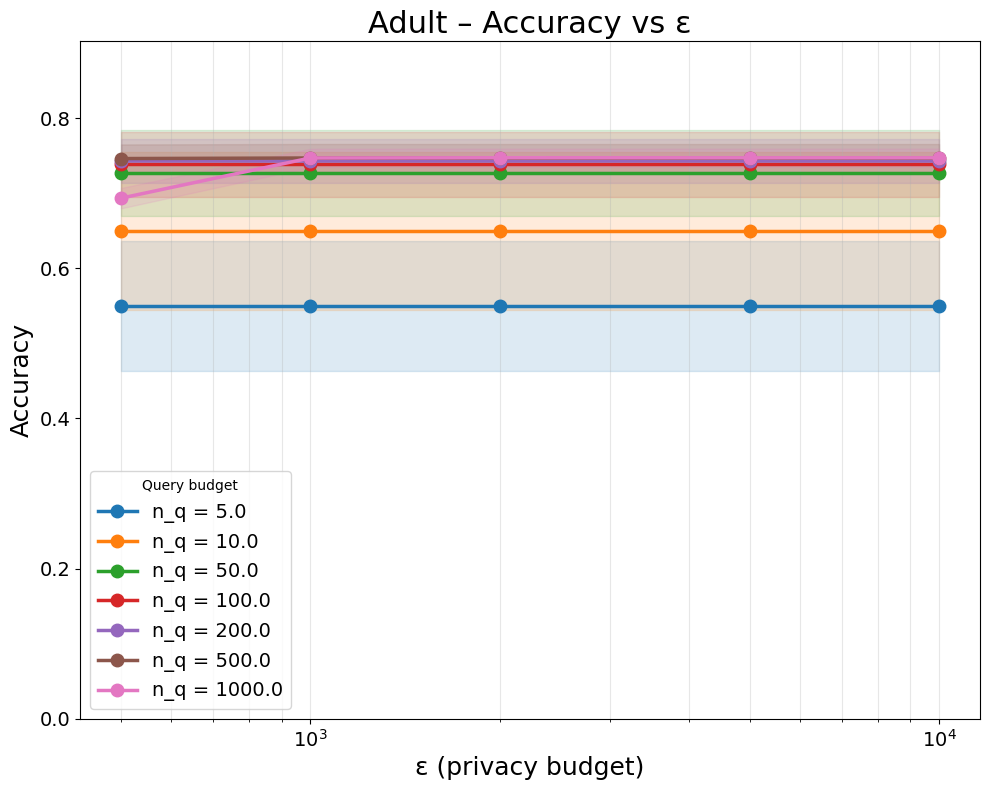

In [53]:
# ────────────────── FAIRNESS CURVES (FINAL FIXES) ───────────────────────────
_FAIRNESS_METRICS = ["accuracy"]
_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def _to_list(x):
    if x is None:
        return None
    return list(x) if isinstance(x, (list, tuple, np.ndarray, pd.Series)) else [x]


# --------------------------------------------------------------------------- #
# ε  *fixed*, sweep n_queries  (largest ε plotted first so it sits underneath)
# --------------------------------------------------------------------------- #
def agt_fairness_vs_nqueries(
    df=AGT_HIGH,
    epsilon_vals=None,
    *,
    save=True,
    out_dir=FIGURE_DIR,
    ext=FIGURE_EXTENSION,
    alpha_band=0.15,
    clip_pct=95,
    shade_ci=True,          # ← new flag
):
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    for dataset, g in df.groupby(level="dataset"):
        eps_avail = sorted(g.index.get_level_values("epsilon").unique())
        eps_vals = _to_list(epsilon_vals) or eps_avail
        eps_vals = sorted(eps_vals, reverse=True)   # ← largest first

        for metric in _FAIRNESS_METRICS:
            fig, ax = plt.subplots()

            all_vals = []
            for line_no, eps in enumerate(eps_vals):
                if eps not in eps_avail:
                    continue
                sub = (
                    g.xs((dataset, eps), level=("dataset", "epsilon"))
                      .reset_index()
                      .sort_values("n_queries")
                )

                ax.plot(
                    sub["n_queries"], sub[metric],
                    marker="o", label=f"ε = {eps:g}",
                    color=_COLORS[line_no % len(_COLORS)],
                )
                if shade_ci:
                    ax.fill_between(
                        sub["n_queries"],
                        sub[metric] - sub[f"std_{metric}"],
                        sub[metric] + sub[f"std_{metric}"],
                        alpha=alpha_band,
                        color=_COLORS[line_no % len(_COLORS)],
                    )
                else:
                    ax.plot(
                        sub["n_queries"],
                        sub[metric] - sub[f"std_{metric}"],
                        linestyle="--",
                        linewidth=1,
                        color=_COLORS[line_no % len(_COLORS)],
                    )
                    ax.plot(
                        sub["n_queries"],
                        sub[metric] + sub[f"std_{metric}"],
                        linestyle="--",
                        linewidth=1,
                        color=_COLORS[line_no % len(_COLORS)],
                    )

            # ───────── smart y-limit (robust) ───────────────────────────────
            finite = np.asarray(all_vals, dtype=float)
            finite = finite[np.isfinite(finite)]
            if finite.size:                      # at least one real number
                y_top = np.nanpercentile(finite, clip_pct)
                ax.set_ylim(0, y_top * 1.05)
            else:
                # nothing finite; fall back to default auto-limits
                ax.set_ylim(bottom=0)

            ax.set_xscale("log")
            ax.set_xlabel("Number of Queries")
            ax.set_ylabel(metric.replace("_", " ").title())
            ax.set_title(f"{dataset.capitalize()} – {metric.replace('_',' ').title()} vs n₍queries₎")
            ax.grid(True, which="both", axis="x", alpha=0.3)
            ax.legend(title="ε value", loc="best")

            plt.tight_layout()
            if save and dataset == "acs_income":
                fig.savefig(out_dir / f"{dataset}_agt_{metric}_vs_nqueries.{ext}", dpi=300)
            plt.show()


# --------------------------------------------------------------------------- #
# n_queries fixed, sweep ε  (optional y-max for zoom)
# --------------------------------------------------------------------------- #
def agt_fairness_vs_epsilon(
    df=AGT_HIGH,
    n_queries_vals=None,
    *,
    save=True,
    out_dir=FIGURE_DIR,
    ext=FIGURE_EXTENSION,
    alpha_band=0.15,
    y_max=None,          # pass a number to override the auto limit
    y_pad=0.15,          # 15 % head-room above the tallest CI
):
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    for dataset, g in df.groupby(level="dataset"):
        qs_avail = sorted(g.index.get_level_values("n_queries").unique())
        n_q_vals = _to_list(n_queries_vals) or qs_avail

        for metric in _FAIRNESS_METRICS:
            fig, ax = plt.subplots()
            all_vals = []   # collect means ± std to size the y-axis

            for line_no, nq in enumerate(n_q_vals):
                if nq not in qs_avail:
                    continue

                sub = (
                    g.xs((dataset, slice(None), nq),
                         level=("dataset", "epsilon", "n_queries"))
                      .reset_index()
                      .sort_values("epsilon")
                )

                ax.plot(
                    sub["epsilon"], sub[metric],
                    marker="o", label=f"n_q = {nq}",
                    color=_COLORS[line_no % len(_COLORS)],
                )
                ax.fill_between(
                    sub["epsilon"],
                    sub[metric] - sub[f"std_{metric}"],
                    sub[metric] + sub[f"std_{metric}"],
                    alpha=alpha_band,
                    color=_COLORS[line_no % len(_COLORS)],
                )

                # stash values for adaptive y-axis  --------------------------
                all_vals.extend(
                    (sub[metric] - sub[f"std_{metric}"]).tolist()
                    + (sub[metric] + sub[f"std_{metric}"]).tolist()
                )

            # ---------------- adaptive y-limit -----------------------------
            if y_max is None:
                finite = np.asarray(all_vals, dtype=float)
                finite = finite[np.isfinite(finite)]
                if finite.size:
                    ymax = finite.max() * (1 + y_pad)
                else:
                    ymax = plt.gca().get_ylim()[1]
            else:
                ymax = y_max

            ax.set_xscale("log")
            ax.set_ylim(bottom=0, top=ymax)
            ax.set_xlabel("ε (privacy budget)")
            ax.set_ylabel(metric.replace("_", " ").title())
            ax.set_title(f"{dataset.capitalize()} – {metric.replace('_',' ').title()} vs ε")
            ax.grid(True, which="both", axis="x", alpha=0.3)
            ax.legend(title="Query budget", loc="best")

            plt.tight_layout()
            if save:
                fig.savefig(out_dir / f"{dataset}_agt_{metric}_vs_epsilon.{ext}", dpi=300)
            plt.show()

# ──────────────────────────── DRIVER EXAMPLES ───────────────────────────────
# regenerate n_queries plot (largest ε drawn first)
agt_fairness_vs_nqueries(save=True, shade_ci=False)

# zoom-in version, y_max = 0.05 for extra tight view
agt_fairness_vs_epsilon(save=True)

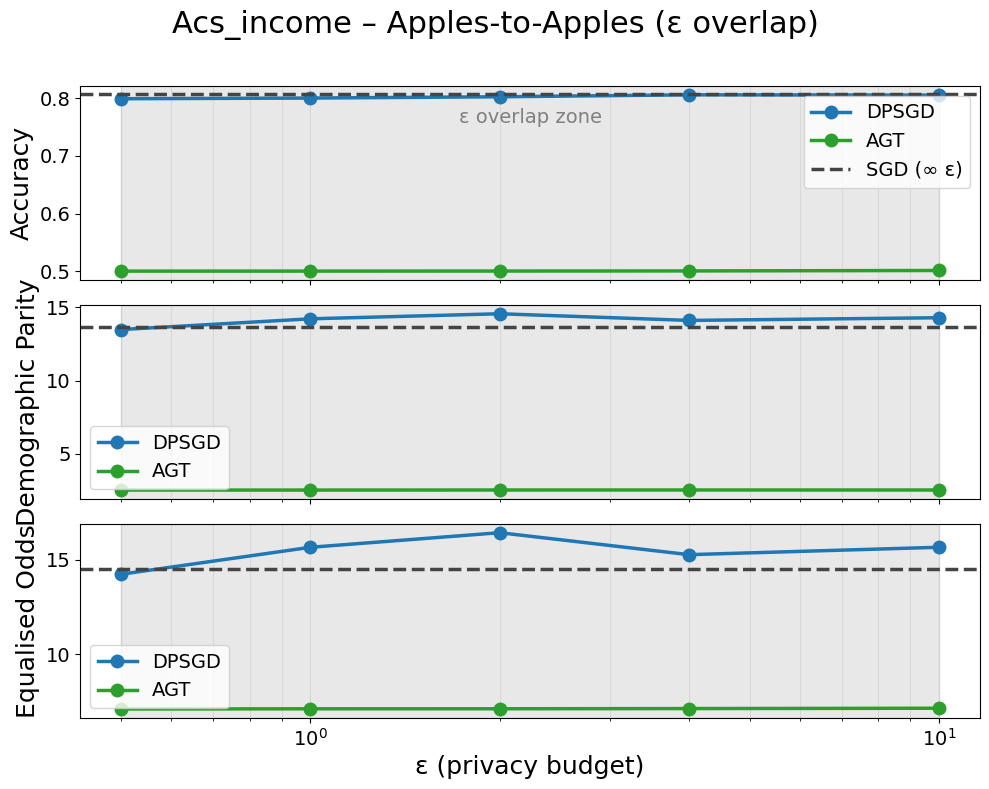

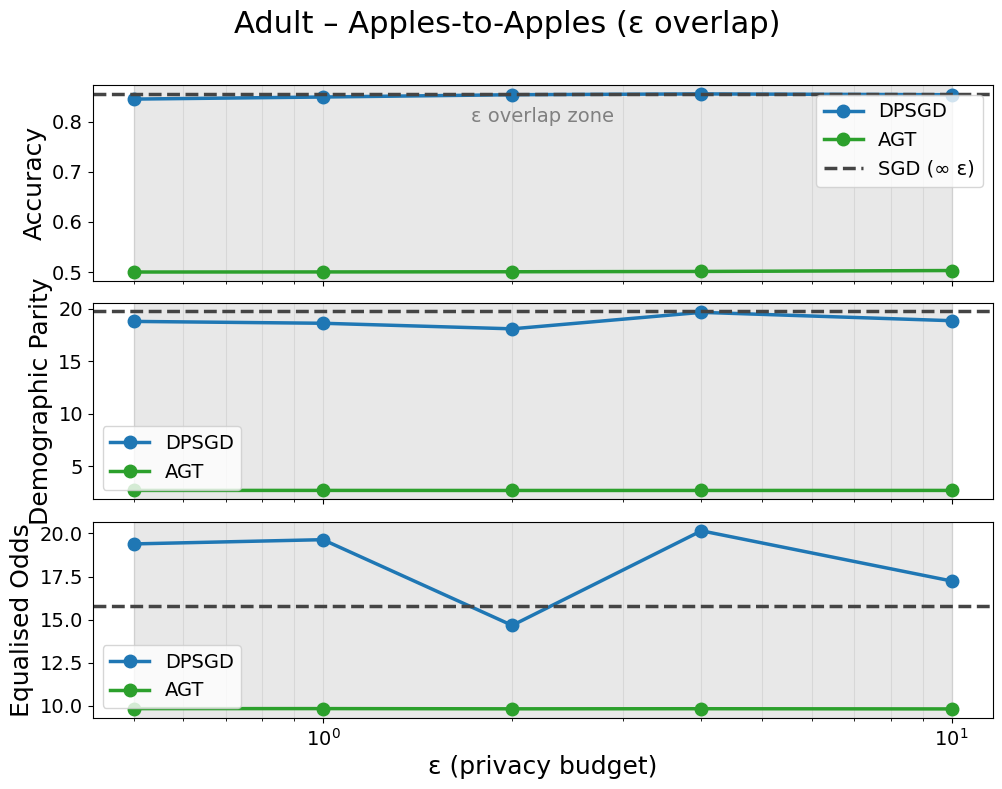

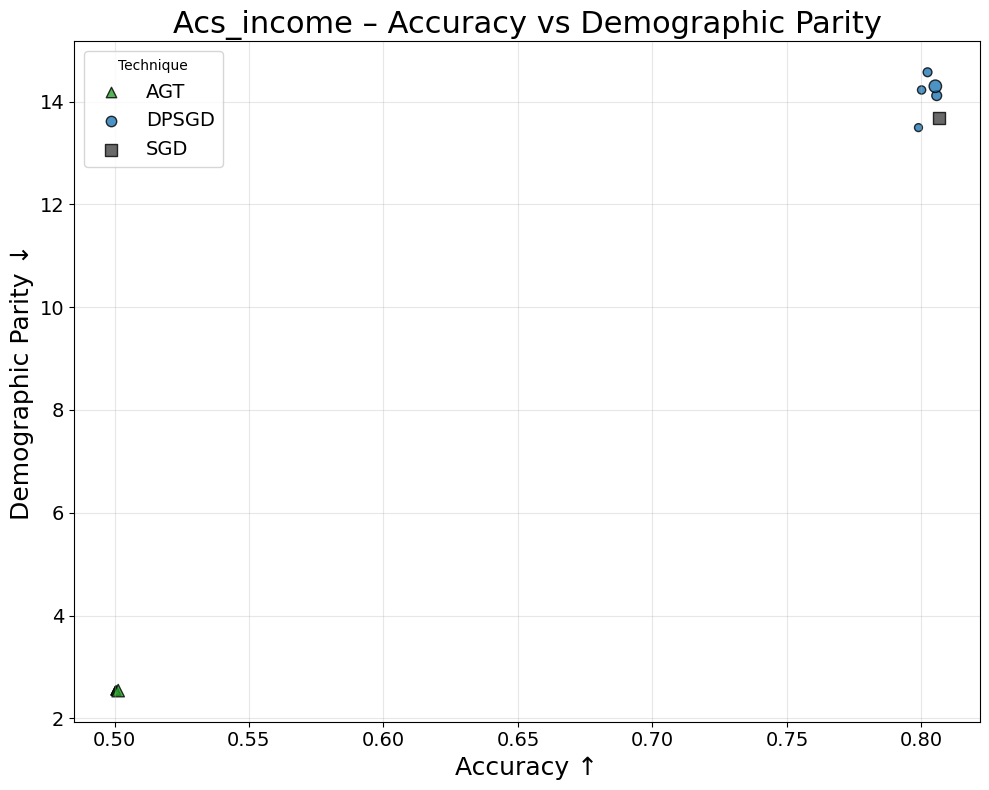

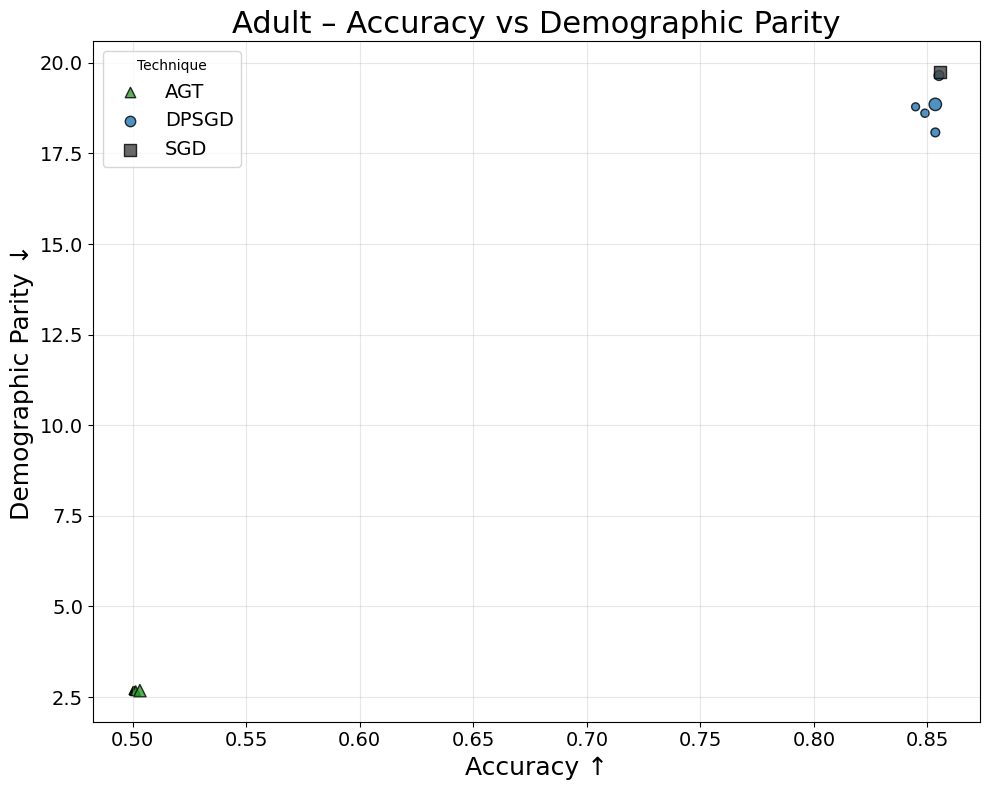

In [51]:
# =============================================================================
# 1) 3-panel “Apples-to-Apples” (accuracy + two fairness metrics)
# 2) Scatter version (accuracy vs fairness)
# =============================================================================
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------- #
# 1. THREE-PANEL VERSION
# --------------------------------------------------------------------------- #
def apples_to_apples(
    df_regular,
    *,
    agt_n_queries="max",      # "max", "min", or explicit int
    grey_alpha=0.18,
    save=True,
    out_dir=FIGURE_DIR,
    ext=FIGURE_EXTENSION,
):
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    tech_colors = {"sgd": "#444444", "dpsgd": _COLORS[0], "agt": _COLORS[2]}
    FAIRNESS_METRICS = ["demographic_parity", "equalised_odds"]

    for dataset, g in df_regular.groupby(level="dataset"):
        eps_dpsgd = set(g[g["technique"] == "dpsgd"].index.get_level_values("epsilon"))
        eps_agt   = set(g[g["technique"] == "agt"].index.get_level_values("epsilon"))
        overlap_eps = sorted(eps_dpsgd & eps_agt)
        if not overlap_eps:
            print(f"[skip] {dataset}: no common ε between DPSGD and AGT.")
            continue

        # choose AGT query budget
        agt_qs = sorted(g[g["technique"] == "agt"].index.get_level_values("n_queries").unique())
        if agt_n_queries == "max":
            sel_q = max(agt_qs)
        elif agt_n_queries == "min":
            sel_q = min(agt_qs)
        else:
            sel_q = int(agt_n_queries)
            if sel_q not in agt_qs:
                raise ValueError(f"{sel_q} not in AGT budgets {agt_qs}")

        # gather rows
        rows = []
        sgd_row = g[g["technique"] == "sgd"].iloc[0]
        for eps in overlap_eps:
            rows.append({"tech": "dpsgd", "epsilon": eps,
                         **g[(g["technique"]=="dpsgd") &
                            (g.index.get_level_values("epsilon")==eps)].iloc[0].to_dict()})
            rows.append({"tech": "agt", "epsilon": eps,
                         **g[(g["technique"]=="agt") &
                            (g.index.get_level_values("epsilon")==eps) &
                            (g.index.get_level_values("n_queries")==sel_q)].iloc[0].to_dict()})
        df_plot = pd.DataFrame(rows)

        # figure with 3 rows
        fig, axes = plt.subplots(3, 1, sharex=True, figsize=FIGSIZE)
        fig.suptitle(f"{dataset.capitalize()} – Apples-to-Apples (ε overlap)",
                     fontsize=TITLE_SIZE)

        # grey band across all axes
        for ax in axes:
            ax.axvspan(min(overlap_eps), max(overlap_eps),
                       color="grey", alpha=grey_alpha, zorder=0)

        # ------------- panel A: accuracy ------------------------------------
        ax_acc = axes[0]
        for tech in ("dpsgd", "agt"):
            sub = df_plot[df_plot["tech"]==tech]
            ax_acc.plot(sub["epsilon"], sub["accuracy"],
                        marker="o", label=tech.upper(),
                        color=tech_colors[tech])
        ax_acc.axhline(sgd_row["accuracy"], linestyle="--",
                       color=tech_colors["sgd"], label="SGD (∞ ε)")
        ax_acc.set_xscale("log")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.grid(True, which="both", axis="x", alpha=0.3)
        ax_acc.legend()

        # ------------- panels B/C: fairness ---------------------------------
        for ax, metric in zip(axes[1:], FAIRNESS_METRICS):
            for tech in ("dpsgd", "agt"):
                sub = df_plot[df_plot["tech"]==tech]
                ax.plot(sub["epsilon"], sub[metric],
                        marker="o", label=tech.upper(),
                        color=tech_colors[tech])
            ax.axhline(sgd_row[metric], linestyle="--",
                       color=tech_colors["sgd"])
            ax.set_xscale("log")
            ax.set_ylabel(metric.replace('_',' ').title())
            ax.grid(True, which="both", axis="x", alpha=0.3)
            ax.legend()

        axes[-1].set_xlabel("ε (privacy budget)")

        # annotate overlap band midpoint
        mid_log_eps = np.sqrt(min(overlap_eps)*max(overlap_eps))
        ax_acc.text(mid_log_eps, sgd_row["accuracy"]*0.97,
                    "ε overlap zone", ha="center", va="top",
                    fontsize=TICK_SIZE, color="grey")

        plt.tight_layout(rect=[0,0,1,0.96])
        if save:
            fig.savefig(out_dir / f"{dataset}_apples_to_apples.{ext}", dpi=300)
        plt.show()


# --------------------------------------------------------------------------- #
# 2. SCATTER: accuracy vs fairness (one plot per dataset)
# --------------------------------------------------------------------------- #
def apples_to_apples_scatter(
    df_regular,
    *,
    fairness_metric="demographic_parity",
    agt_n_queries="max",
    save=True,
    out_dir=FIGURE_DIR,
    ext=FIGURE_EXTENSION,
):
    out_dir = Path(out_dir)
    if save:
        out_dir.mkdir(parents=True, exist_ok=True)

    marker_map = {"sgd":"s", "dpsgd":"o", "agt":"^"}
    tech_colors = {"sgd": "#444444", "dpsgd": _COLORS[0], "agt": _COLORS[2]}

    for dataset, g in df_regular.groupby(level="dataset"):
        eps_dpsgd = set(g[g["technique"]=="dpsgd"].index.get_level_values("epsilon"))
        eps_agt   = set(g[g["technique"]=="agt"].index.get_level_values("epsilon"))
        overlap_eps = sorted(eps_dpsgd & eps_agt)
        if not overlap_eps:
            continue

        agt_qs = sorted(g[g["technique"]=="agt"].index.get_level_values("n_queries").unique())
        sel_q = max(agt_qs) if agt_n_queries=="max" else (min(agt_qs) if agt_n_queries=="min" else int(agt_n_queries))

        rows=[]
        rows.append({"tech":"sgd", "epsilon":np.inf,
                     **g[g["technique"]=="sgd"].iloc[0].to_dict()})
        for eps in overlap_eps:
            rows.append({"tech":"dpsgd","epsilon":eps,
                         **g[(g["technique"]=="dpsgd") &
                            (g.index.get_level_values("epsilon")==eps)].iloc[0].to_dict()})
            rows.append({"tech":"agt","epsilon":eps,
                         **g[(g["technique"]=="agt") &
                            (g.index.get_level_values("epsilon")==eps) &
                            (g.index.get_level_values("n_queries")==sel_q)].iloc[0].to_dict()})
        df_p = pd.DataFrame(rows)

        fig, ax = plt.subplots(figsize=FIGSIZE)
        for tech, sub in df_p.groupby("tech"):
            sizes = 80 if tech=="sgd" else (30 + 50*(sub["epsilon"]/max(overlap_eps)))
            ax.scatter(sub["accuracy"], sub[fairness_metric],
                       s=sizes, marker=marker_map[tech],
                       color=tech_colors[tech], alpha=0.8, label=tech.upper(),
                       edgecolors="k")
        ax.set_xlabel("Accuracy ↑")
        ax.set_ylabel(fairness_metric.replace('_',' ').title()+" ↓")
        ax.set_title(f"{dataset.capitalize()} – Accuracy vs {fairness_metric.replace('_',' ').title()}")
        ax.grid(True, alpha=0.3)
        ax.legend(title="Technique", loc="best")
        plt.tight_layout()
        if save:
            fig.savefig(out_dir / f"{dataset}_scatter_{fairness_metric}.{ext}", dpi=300)
        plt.show()


# ---------------------------------------------------------------------------
# USAGE EXAMPLES
# ---------------------------------------------------------------------------
apples_to_apples(df_regular, agt_n_queries="max", save=True)  # 3-panel figs
apples_to_apples_scatter(df_regular, fairness_metric="demographic_parity",
                         agt_n_queries="max", save=True)      # scatter figs